<h1 id="businesscase"><strong>Business case: detection flowering stage tulips </strong></h1>

The flowering stage of tulips gives a range of information about the quality of the tulip bulbs. Healthy tulips are flowering at the same time, bulbs that are not flowering are not healthy and most of the time infected with diseases or plaques. Tulips that are not flowering can also be in a degenerative stage. For the grower it's valuable information how many flowers are flowering against the amount of planted bulbs. 

> recommendations
integrate the HSV color selector in an application  


<h1><strong>Import libraries </strong></h1>

In [14]:
import os, fnmatch, math
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h1><strong>Set image path and HSV colors</strong></h1>
See /scripts/selectHSVcolors.py<br/><br/>  
lowHsv = np.array([Hmin, Smin, vMin])<br/>
upHsv = np.array([Hmax, Smax, vMax])

In [15]:
# Load image
pathRoot = r"C:\Users\kristel\stenden\data\imageslarge"

# pathImage = pathRoot + r"\GX010041_frame2024-04-13T09-39-45.599000.jpg"
# pathImage = pathRoot + r"\GX010041_frame2024-04-13T09-39-47.599000.jpg"
# pathImage = pathRoot + r"\GX010041_frame2024-04-13T09-39-49.599000.jpg"
# pathImage = pathRoot + r"\GX010041_frame2024-04-13T09-39-51.599000.jpg"
pathImage = pathRoot + r"\GX010041_frame2024-04-13T09-39-53.599000.jpg"

# set HSV colors

lowHsv = np.array([78, 0, 51])

upHsv = np.array([179, 255, 255])

<h1><strong>Methods pre-processing</strong></h1>

In [16]:
# Calculates the distance between the contours, numpy array's of 2 contours with coordinates including rect:
def calculate_contour_distance(contour1, contour2):
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    c_x1 = x1 + w1 / 2
    c_y1 = y1 + h1 / 2

    x2, y2, w2, h2 = cv2.boundingRect(contour2)
    c_x2 = x2 + w2 / 2
    c_y2 = y2 + h2 / 2

    return max(abs(c_x1 - c_x2) - (w1 + w2) / 2, abs(c_y1 - c_y2) - (h1 + h2) / 2)


def merge_contours(contour1, contour2):
    return np.concatenate((contour1, contour2), axis=0)


def agglomerative_cluster(contours, threshold_distance=60.0):
    current_contours = contours
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None

        for x in range(len(current_contours) - 1):
            for y in range(x + 1, len(current_contours)):
                distance = calculate_contour_distance(
                    current_contours[x], current_contours[y]
                )

                if min_distance is None:
                    min_distance = distance
                    min_coordinate = (x, y)
                elif distance < min_distance:
                    min_distance = distance
                    min_coordinate = (x, y)

        if min_distance < threshold_distance:
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(
                current_contours[index1], current_contours[index2]
            )
            del current_contours[index2]
        else:
            break

    return current_contours

<h1><strong>Methods processing</strong></h1>

In [17]:
def crop_image(pathImage=None):
    # Load image
    img = cv2.imread(pathImage)

    # Crop image from the top to region of interest
    height, width, d = img.shape[:3]
    percentageROI = round(height / 4.1)
    x, y, w, h = 0, percentageROI, width, height
    imgRoi = img[y : y + h, x : x + w]

    return imgRoi


# Create mask
def createmask_image(img, lowHsv, upHsv):

    # Convert image to HSV channel
    imgHsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Set HSV range colors
    colorMask = cv2.inRange(imgHsv, lowHsv, upHsv)
    # Combine image with created colorMask
    imgMask = cv2.bitwise_and(imgHsv, imgHsv, mask=colorMask)
    return imgMask


def contours_image(img=None):

    # Convert image to gray channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)

    ret, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

    return contours


def filter_contours(contours):

    newContours = []

    for cnt in contours:
        rect = cv2.minAreaRect(cnt)

        width = rect[1][0]
        height = rect[1][1]

        if width > 70 and height > 70:

            newContours.append(cnt)

    return newContours



def writeResults(img, txt):
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (30, 200)
    fontScale = 4
    fontColor = (255, 255, 255)
    thickness = 20
    lineType = cv2.LINE_AA
    cv2.putText(
        img,
        "" + str(txt),
        bottomLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        thickness,
        lineType,
        False,
    )

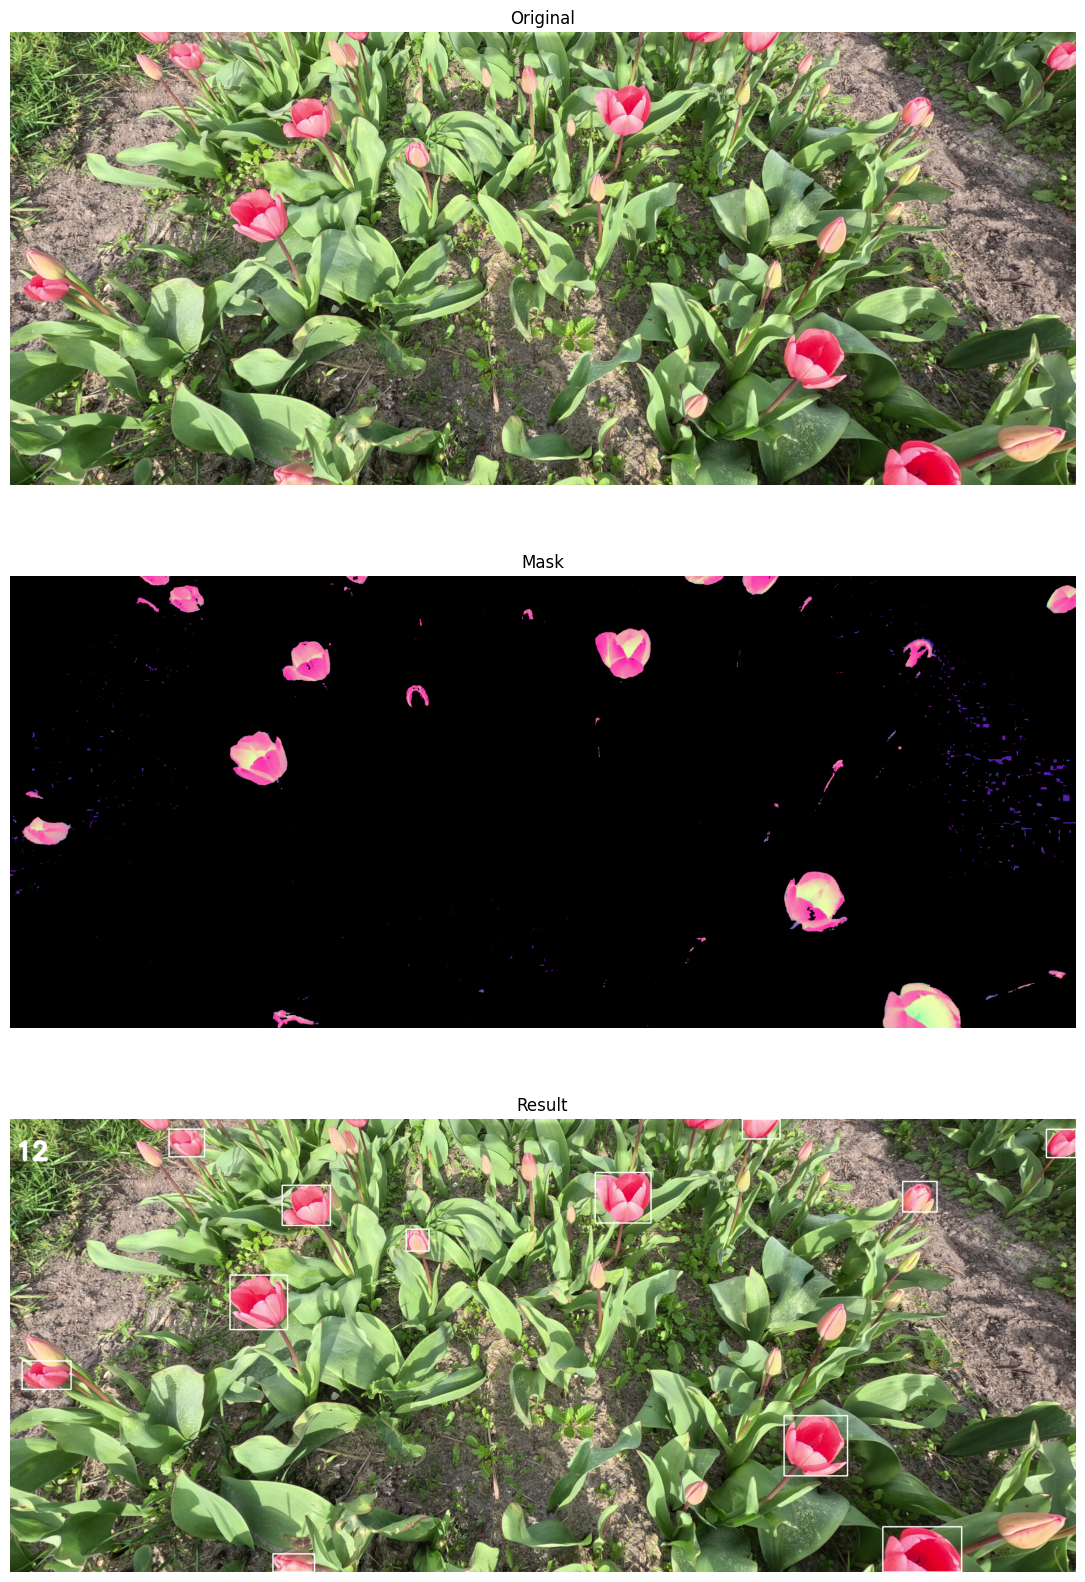

In [18]:
# Load image
if os.path.exists(pathImage):

    img = crop_image(pathImage)

    # Create subplots
    f, plot = plt.subplots(3, figsize=(30, 20))

    # Show current result
    plot[0].imshow(img[:, :, ::-1])
    plot[0].set_title("Original")
    plot[0].axis(False)

    img = createmask_image(img, lowHsv, upHsv)

    plot[1].imshow(img[:, :, ::-1])
    plot[1].set_title("Mask")
    plot[1].axis(False)

    cnts = contours_image(img)
    filterCnts = filter_contours(cnts)
    cntsList = list(filterCnts)
    currentCnts = agglomerative_cluster(cntsList, threshold_distance=-110.0)

    imgOriginal = crop_image(pathImage)

    i = 0
    for cnt in currentCnts:

        rect = cv2.minAreaRect(cnt)
        width = rect[1][0]
        height = rect[1][1]

        if width > 0 and height > 0:
            i = i + 1
            boundingRect = cv2.boundingRect(cnt)
            x, y, w, h = boundingRect
            if w > 400 and h > 400:
                i = i + 1

            cv2.rectangle(imgOriginal, (x, y), (x + w, y + h), (255, 255, 255), 6)

    # Write total result on image
    writeResults(imgOriginal, i)

    plot[2].imshow(imgOriginal[:, :, ::-1])
    plot[2].set_title("Result")
    plot[2].axis(False)

else:
    print("Warning: path or/and image does not exist")